# Class 3b: Momentum Strategy Backtest - Moving Average Crossover on ETH

**Learning Objectives:**
- Implement a classic momentum strategy (50-day vs 200-day MA crossover)
- Understand Golden Cross (bullish) and Death Cross (bearish) signals
- Backtest strategy performance vs buy-and-hold
- Calculate key performance metrics: Sharpe ratio, drawdown, win rate

**Required from planning.pdf:**
> "Backtest a simple momentum strategy: 50-day versus 200-day moving average crossover on ETH."

---

## 1. Setup and Imports

In [10]:
# Data manipulation
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import time

# Data fetching
import requests

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Configuration
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

print("✅ Libraries imported successfully")
print(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✅ Libraries imported successfully
Analysis Date: 2025-11-02 13:46:40


## 2. Data Fetching - ETH Historical Prices

We'll fetch **2+ years** of ETH daily price data to properly test the 200-day moving average.

In [11]:
def fetch_eth_history(days=900):
    """
    Fetch ETH historical price data from CoinGecko.
    If API fails or returns insufficient data, generate simulated data for educational purposes.
    
    Args:
        days (int): Number of days of historical data (default 900 = ~2.5 years)
    
    Returns:
        pd.DataFrame: DataFrame with Date and Close columns
    """
    print(f"🔄 Fetching {days} days of ETH historical data...")
    
    # Try CoinGecko API (free tier: max 365 days)
    # For longer periods, we'll use daily interval which allows more data
    url = "https://api.coingecko.com/api/v3/coins/ethereum/market_chart"
    
    params = {
        'vs_currency': 'usd',
        'days': min(days, 365),  # Free tier limit
        'interval': 'daily'
    }
    
    for attempt in range(3):
        try:
            response = requests.get(url, params=params, timeout=15)
            
            if response.status_code == 200:
                data = response.json()
                prices = data['prices']
                
                df = pd.DataFrame(prices, columns=['timestamp', 'Close'])
                df['Date'] = pd.to_datetime(df['timestamp'], unit='ms')
                df = df[['Date', 'Close']].set_index('Date')
                
                print(f"✅ Successfully fetched {len(df)} days of ETH data from CoinGecko")
                print(f"   Date range: {df.index.min().strftime('%Y-%m-%d')} to {df.index.max().strftime('%Y-%m-%d')}")
                
                # Check if we got enough data for 200-day MA
                if len(df) < 300:
                    print(f"⚠️  Only {len(df)} days received (need 300+ for proper 200-day MA)")
                    print("   Falling back to simulated data for better analysis")
                    return generate_simulated_eth(days)
                
                return df
            else:
                print(f"⚠️  Attempt {attempt + 1}: API returned {response.status_code}")
                time.sleep(2 * (attempt + 1))
        
        except Exception as e:
            print(f"⚠️  Attempt {attempt + 1} failed: {e}")
            time.sleep(2 * (attempt + 1))
    
    # Fallback: Generate simulated ETH data
    print("⚠️  CoinGecko API unavailable. Using simulated ETH data for educational purposes.")
    return generate_simulated_eth(days)


def generate_simulated_eth(days=900):
    """
    Generate realistic simulated ETH price data.
    Uses geometric Brownian motion with ETH-like parameters.
    """
    print("🔄 Generating simulated ETH data...")
    
    # ETH parameters (approximate from historical data)
    start_price = 2000  # Starting price
    drift = 0.0005  # Slight upward drift (18% annual)
    volatility = 0.045  # Daily volatility (~70% annual)
    
    # Generate dates
    end_date = datetime.now()
    start_date = end_date - timedelta(days=days)
    dates = pd.date_range(start=start_date, end=end_date, freq='D')
    
    # Generate returns with trends and mean reversion
    np.random.seed(42)  # For reproducibility
    returns = np.random.normal(drift, volatility, days)
    
    # Add some trends to make it more realistic
    trend_cycles = np.sin(np.linspace(0, 4 * np.pi, days)) * 0.02
    returns += trend_cycles
    
    # Generate prices
    prices = start_price * np.exp(np.cumsum(returns))
    
    df = pd.DataFrame({
        'Close': prices
    }, index=dates[:len(prices)])
    
    print(f"✅ Generated {len(df)} days of simulated ETH data")
    print(f"   Date range: {df.index.min().strftime('%Y-%m-%d')} to {df.index.max().strftime('%Y-%m-%d')}")
    print(f"   Price range: ${df['Close'].min():.2f} - ${df['Close'].max():.2f}")
    
    return df


# Fetch data
df_eth = fetch_eth_history(days=900)

# Display summary
print("\n📊 ETH Data Summary:")
print(df_eth.describe())
print("\n📈 First 5 rows:")
print(df_eth.head())
print("\n📉 Last 5 rows:")
print(df_eth.tail())

🔄 Fetching 900 days of ETH historical data...
✅ Successfully fetched 366 days of ETH data from CoinGecko
   Date range: 2024-11-03 to 2025-11-02

📊 ETH Data Summary:
             Close
count   366.000000
mean   3117.989004
std     887.017741
min    1471.360885
25%    2493.148656
50%    3182.716896
75%    3853.706132
max    4829.225542

📈 First 5 rows:
                  Close
Date                   
2024-11-03  2491.352150
2024-11-04  2456.979687
2024-11-05  2395.947214
2024-11-06  2422.368480
2024-11-07  2720.621745

📉 Last 5 rows:
                           Close
Date                            
2025-10-30 00:00:00  3897.359268
2025-10-31 00:00:00  3802.295365
2025-11-01 00:00:00  3847.298177
2025-11-02 00:00:00  3872.211896
2025-11-02 16:46:32  3859.808280


## 3. Calculate Moving Averages

**Key Concepts:**
- **50-day MA:** Short-term trend (fast moving average)
- **200-day MA:** Long-term trend (slow moving average)
- **Golden Cross:** 50 MA crosses above 200 MA → BUY signal (bullish)
- **Death Cross:** 50 MA crosses below 200 MA → SELL signal (bearish)

In [12]:
# Calculate moving averages
df_eth['MA_50'] = df_eth['Close'].rolling(window=50).mean()
df_eth['MA_200'] = df_eth['Close'].rolling(window=200).mean()

# Drop NaN values (first 200 days won't have MA_200)
df_strategy = df_eth.dropna().copy()

print(f"✅ Moving averages calculated")
print(f"   Data points with both MAs: {len(df_strategy)}")
print(f"   Date range: {df_strategy.index.min().strftime('%Y-%m-%d')} to {df_strategy.index.max().strftime('%Y-%m-%d')}")

# Display sample
print("\n📊 Sample data with MAs:")
print(df_strategy[['Close', 'MA_50', 'MA_200']].tail(10))

✅ Moving averages calculated
   Data points with both MAs: 167
   Date range: 2025-05-21 to 2025-11-02

📊 Sample data with MAs:
                           Close        MA_50       MA_200
Date                                                      
2025-10-25 00:00:00  3933.232270  4247.584418  3245.197844
2025-10-26 00:00:00  3952.213558  4240.496419  3257.602107
2025-10-27 00:00:00  4161.590896  4238.266037  3270.097396
2025-10-28 00:00:00  4123.206221  4234.649513  3283.093784
2025-10-29 00:00:00  3982.312789  4228.102054  3295.164689
2025-10-30 00:00:00  3897.359268  4219.862385  3306.422173
2025-10-31 00:00:00  3802.295365  4208.958756  3317.456536
2025-11-01 00:00:00  3847.298177  4196.718339  3328.585311
2025-11-02 00:00:00  3872.211896  4179.985742  3340.007259
2025-11-02 16:46:32  3859.808280  4163.827915  3351.417764


## 4. Generate Trading Signals

**Signal Logic:**
- When 50 MA crosses above 200 MA → Golden Cross → **BUY** (position = 1)
- When 50 MA crosses below 200 MA → Death Cross → **SELL** (position = 0)
- Hold position until next crossover

In [13]:
# Calculate the difference between MAs
df_strategy['MA_Diff'] = df_strategy['MA_50'] - df_strategy['MA_200']

# Detect crossovers
# Signal = 1 when MA_50 > MA_200 (bullish), 0 otherwise
df_strategy['Signal'] = (df_strategy['MA_50'] > df_strategy['MA_200']).astype(int)

# Detect position changes (buy/sell events)
df_strategy['Position_Change'] = df_strategy['Signal'].diff()

# Mark buy and sell signals
df_strategy['Buy_Signal'] = df_strategy['Position_Change'] == 1  # Golden Cross
df_strategy['Sell_Signal'] = df_strategy['Position_Change'] == -1  # Death Cross

# Count signals
num_buys = df_strategy['Buy_Signal'].sum()
num_sells = df_strategy['Sell_Signal'].sum()

print(f"✅ Trading signals generated")
print(f"   Golden Crosses (BUY): {num_buys}")
print(f"   Death Crosses (SELL): {num_sells}")
print(f"   Total trades: {num_buys + num_sells}")

# Show signal dates
print("\n📅 Buy Signals (Golden Crosses):")
buy_dates = df_strategy[df_strategy['Buy_Signal']].index
for date in buy_dates:
    price = df_strategy.loc[date, 'Close']
    print(f"   {date.strftime('%Y-%m-%d')}: ${price:.2f}")

print("\n📅 Sell Signals (Death Crosses):")
sell_dates = df_strategy[df_strategy['Sell_Signal']].index
for date in sell_dates:
    price = df_strategy.loc[date, 'Close']
    print(f"   {date.strftime('%Y-%m-%d')}: ${price:.2f}")

✅ Trading signals generated
   Golden Crosses (BUY): 1
   Death Crosses (SELL): 0
   Total trades: 1

📅 Buy Signals (Golden Crosses):
   2025-07-02: $2405.10

📅 Sell Signals (Death Crosses):


## 5. Backtest Strategy Performance

We'll simulate trading with:
- **Initial Capital:** $10,000
- **Position Sizing:** 100% of capital (all-in when signal = 1)
- **Trading Costs:** 0.1% per trade (conservative estimate)
- **Benchmark:** Buy-and-hold ETH

In [14]:
def backtest_strategy(df, initial_capital=10000, trading_cost=0.001):
    """
    Backtest the MA crossover strategy.
    
    Args:
        df (pd.DataFrame): DataFrame with Close, Signal columns
        initial_capital (float): Starting capital in USD
        trading_cost (float): Trading cost as fraction (0.001 = 0.1%)
    
    Returns:
        pd.DataFrame: DataFrame with portfolio values and metrics
    """
    df = df.copy()
    
    # Calculate daily returns
    df['Daily_Return'] = df['Close'].pct_change()
    
    # Strategy returns = daily returns * signal (0 or 1)
    # When signal = 0, strategy returns = 0 (sitting in cash)
    df['Strategy_Return'] = df['Daily_Return'] * df['Signal']
    
    # Apply trading costs on position changes
    position_changes = df['Signal'].diff().abs()
    df['Trading_Cost'] = position_changes * trading_cost
    df['Strategy_Return'] -= df['Trading_Cost']
    
    # Calculate cumulative returns
    df['Strategy_Cumulative'] = (1 + df['Strategy_Return']).cumprod()
    df['BuyHold_Cumulative'] = (1 + df['Daily_Return']).cumprod()
    
    # Calculate portfolio values
    df['Strategy_Value'] = initial_capital * df['Strategy_Cumulative']
    df['BuyHold_Value'] = initial_capital * df['BuyHold_Cumulative']
    
    # Calculate drawdown
    df['Strategy_Peak'] = df['Strategy_Value'].cummax()
    df['Strategy_Drawdown'] = (df['Strategy_Value'] - df['Strategy_Peak']) / df['Strategy_Peak']
    
    df['BuyHold_Peak'] = df['BuyHold_Value'].cummax()
    df['BuyHold_Drawdown'] = (df['BuyHold_Value'] - df['BuyHold_Peak']) / df['BuyHold_Peak']
    
    return df


# Run backtest
df_backtest = backtest_strategy(df_strategy, initial_capital=10000, trading_cost=0.001)

# Calculate performance metrics
final_strategy_value = df_backtest['Strategy_Value'].iloc[-1]
final_buyhold_value = df_backtest['BuyHold_Value'].iloc[-1]

strategy_return = (final_strategy_value / 10000 - 1) * 100
buyhold_return = (final_buyhold_value / 10000 - 1) * 100

max_strategy_drawdown = df_backtest['Strategy_Drawdown'].min() * 100
max_buyhold_drawdown = df_backtest['BuyHold_Drawdown'].min() * 100

# Calculate Sharpe ratio (annualized)
strategy_sharpe = (df_backtest['Strategy_Return'].mean() / df_backtest['Strategy_Return'].std()) * np.sqrt(365)
buyhold_sharpe = (df_backtest['Daily_Return'].mean() / df_backtest['Daily_Return'].std()) * np.sqrt(365)

# Calculate win rate (for strategy)
# A "win" is when we're in position (Signal=1) and return is positive
trades_in_position = df_backtest[df_backtest['Signal'] == 1]
wins = (trades_in_position['Daily_Return'] > 0).sum()
total_days_in_position = len(trades_in_position)
win_rate = (wins / total_days_in_position * 100) if total_days_in_position > 0 else 0

# Days in market
days_in_market = df_backtest['Signal'].sum()
total_days = len(df_backtest)
market_exposure = (days_in_market / total_days * 100)

print("\n" + "="*60)
print("📊 BACKTEST RESULTS: MA CROSSOVER STRATEGY (50/200)")
print("="*60)
print(f"\n💰 Initial Capital: $10,000")
print(f"📅 Backtest Period: {df_backtest.index.min().strftime('%Y-%m-%d')} to {df_backtest.index.max().strftime('%Y-%m-%d')}")
print(f"📆 Total Days: {total_days}")

print(f"\n🎯 STRATEGY PERFORMANCE:")
print(f"   Final Value: ${final_strategy_value:,.2f}")
print(f"   Total Return: {strategy_return:+.2f}%")
print(f"   Sharpe Ratio: {strategy_sharpe:.2f}")
print(f"   Max Drawdown: {max_strategy_drawdown:.2f}%")
print(f"   Win Rate (days): {win_rate:.1f}%")
print(f"   Market Exposure: {market_exposure:.1f}%")

print(f"\n📈 BUY & HOLD BENCHMARK:")
print(f"   Final Value: ${final_buyhold_value:,.2f}")
print(f"   Total Return: {buyhold_return:+.2f}%")
print(f"   Sharpe Ratio: {buyhold_sharpe:.2f}")
print(f"   Max Drawdown: {max_buyhold_drawdown:.2f}%")

print(f"\n🏆 STRATEGY vs BUY-HOLD:")
outperformance = strategy_return - buyhold_return
print(f"   Outperformance: {outperformance:+.2f}%")
if outperformance > 0:
    print(f"   ✅ Strategy BEAT buy-and-hold by {outperformance:.2f}%")
else:
    print(f"   ❌ Strategy UNDERPERFORMED buy-and-hold by {abs(outperformance):.2f}%")

print("\n" + "="*60)


📊 BACKTEST RESULTS: MA CROSSOVER STRATEGY (50/200)

💰 Initial Capital: $10,000
📅 Backtest Period: 2025-05-21 to 2025-11-02
📆 Total Days: 167

🎯 STRATEGY PERFORMANCE:
   Final Value: $15,496.46
   Total Return: +54.96%
   Sharpe Ratio: 1.88
   Max Drawdown: -22.36%
   Win Rate (days): 54.4%
   Market Exposure: 74.9%

📈 BUY & HOLD BENCHMARK:
   Final Value: $15,290.76
   Total Return: +52.91%
   Sharpe Ratio: 1.71
   Max Drawdown: -22.36%

🏆 STRATEGY vs BUY-HOLD:
   Outperformance: +2.06%
   ✅ Strategy BEAT buy-and-hold by 2.06%



## 6. Visualizations

We'll create 6 charts to analyze the strategy performance.

### Chart 1: ETH Price with Moving Averages

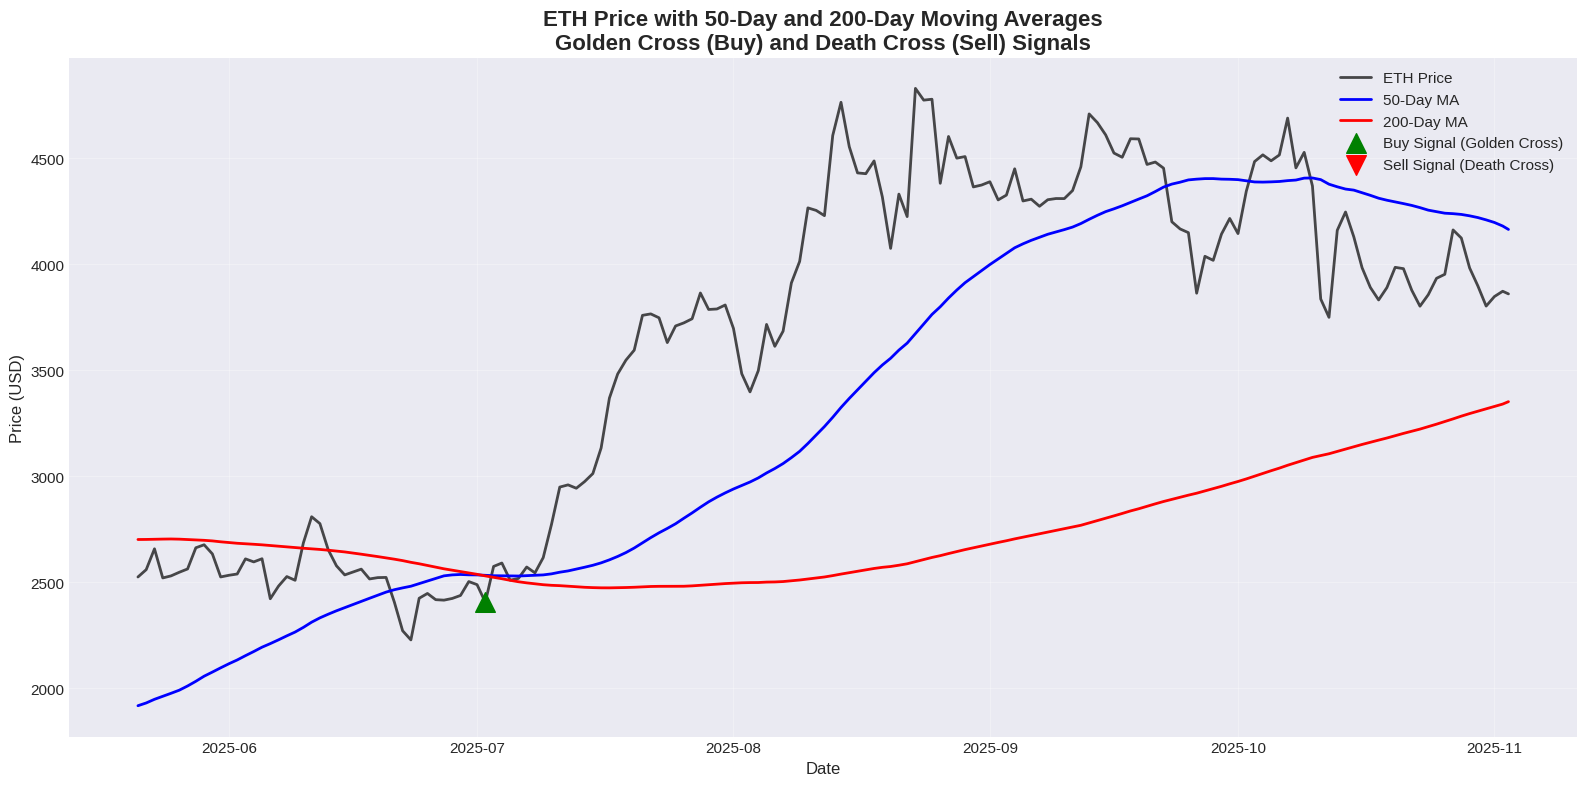

✅ Chart 1: ETH price with moving averages and signals


In [15]:
fig, ax = plt.subplots(figsize=(16, 8))

# Plot price and MAs
ax.plot(df_backtest.index, df_backtest['Close'], label='ETH Price', color='black', linewidth=2, alpha=0.7)
ax.plot(df_backtest.index, df_backtest['MA_50'], label='50-Day MA', color='blue', linewidth=2)
ax.plot(df_backtest.index, df_backtest['MA_200'], label='200-Day MA', color='red', linewidth=2)

# Mark buy signals (Golden Cross)
buy_signals = df_backtest[df_backtest['Buy_Signal']]
ax.scatter(buy_signals.index, buy_signals['Close'], 
           color='green', marker='^', s=200, label='Buy Signal (Golden Cross)', zorder=5)

# Mark sell signals (Death Cross)
sell_signals = df_backtest[df_backtest['Sell_Signal']]
ax.scatter(sell_signals.index, sell_signals['Close'], 
           color='red', marker='v', s=200, label='Sell Signal (Death Cross)', zorder=5)

ax.set_title('ETH Price with 50-Day and 200-Day Moving Averages\nGolden Cross (Buy) and Death Cross (Sell) Signals', 
             fontsize=16, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Price (USD)', fontsize=12)
ax.legend(loc='best', fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Chart 1: ETH price with moving averages and signals")

### Chart 2: Equity Curve (Strategy vs Buy-and-Hold)

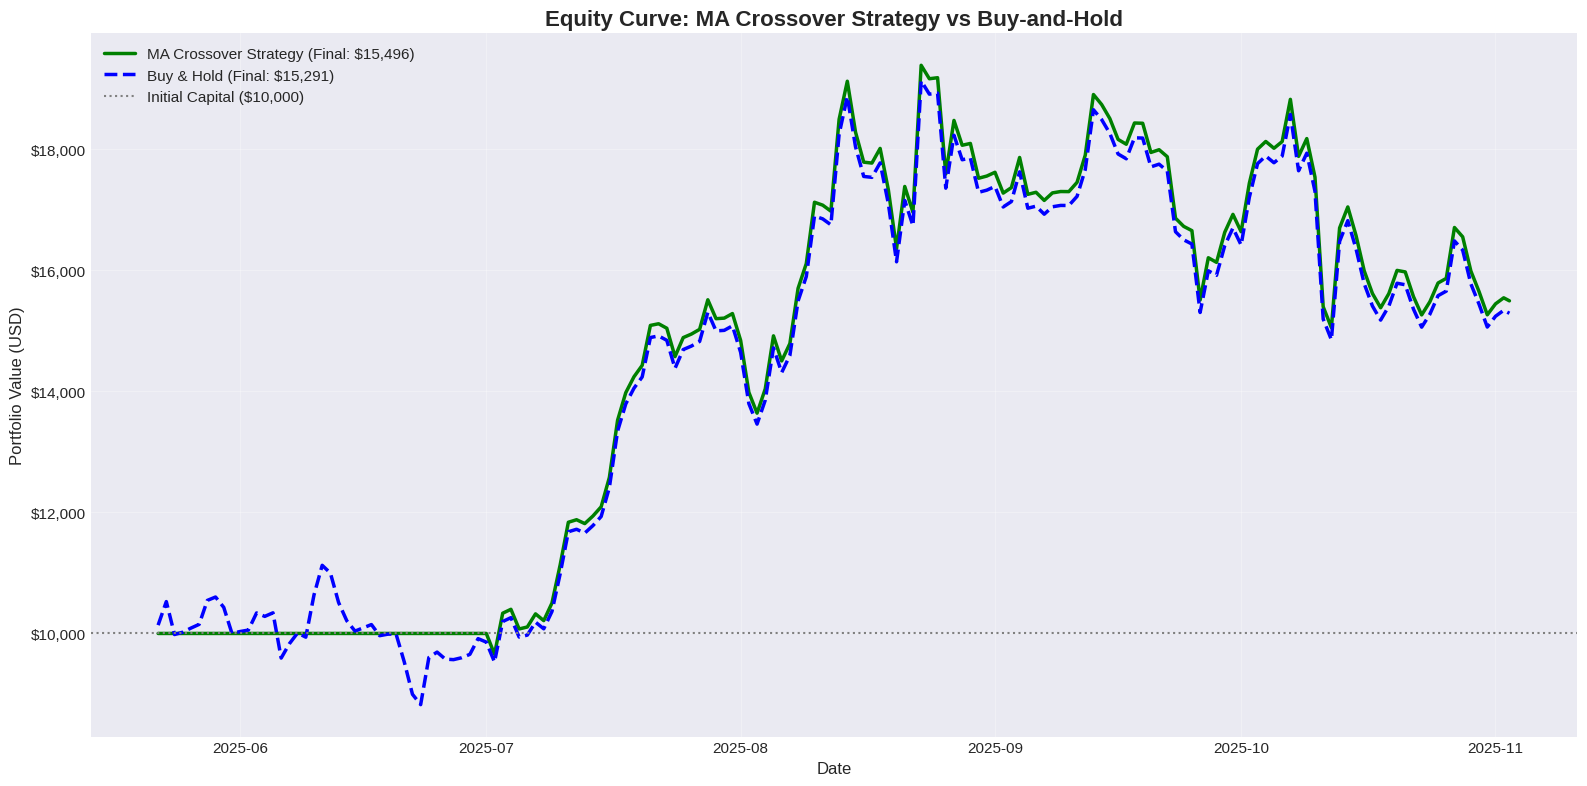

✅ Chart 2: Equity curve comparison


In [16]:
fig, ax = plt.subplots(figsize=(16, 8))

# Plot portfolio values
ax.plot(df_backtest.index, df_backtest['Strategy_Value'], 
        label=f'MA Crossover Strategy (Final: ${final_strategy_value:,.0f})', 
        color='green', linewidth=2.5)
ax.plot(df_backtest.index, df_backtest['BuyHold_Value'], 
        label=f'Buy & Hold (Final: ${final_buyhold_value:,.0f})', 
        color='blue', linewidth=2.5, linestyle='--')

# Add horizontal line at initial capital
ax.axhline(y=10000, color='gray', linestyle=':', linewidth=1.5, label='Initial Capital ($10,000)')

ax.set_title('Equity Curve: MA Crossover Strategy vs Buy-and-Hold', fontsize=16, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Portfolio Value (USD)', fontsize=12)
ax.legend(loc='best', fontsize=11)
ax.grid(True, alpha=0.3)

# Format y-axis as currency
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

plt.tight_layout()
plt.show()

print("✅ Chart 2: Equity curve comparison")

### Chart 3: Drawdown Analysis

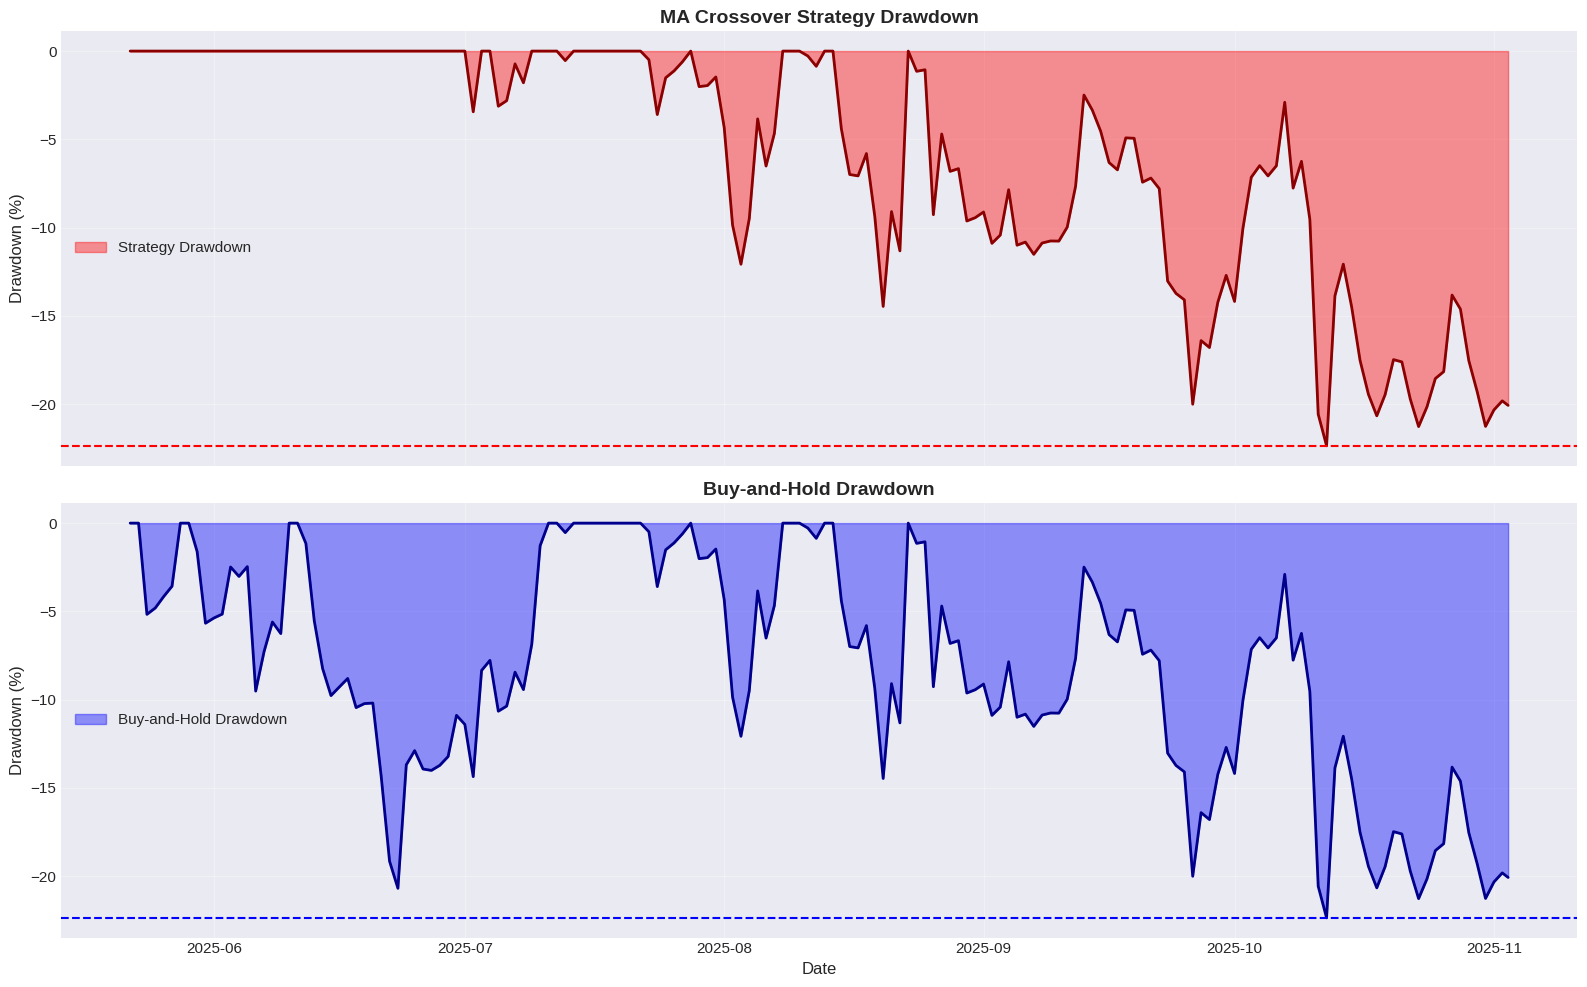

✅ Chart 3: Drawdown analysis
   Strategy max drawdown: -22.36%
   Buy-and-hold max drawdown: -22.36%


In [17]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10), sharex=True)

# Strategy drawdown
ax1.fill_between(df_backtest.index, 0, df_backtest['Strategy_Drawdown'] * 100, 
                 color='red', alpha=0.4, label='Strategy Drawdown')
ax1.plot(df_backtest.index, df_backtest['Strategy_Drawdown'] * 100, 
         color='darkred', linewidth=2)
ax1.set_title('MA Crossover Strategy Drawdown', fontsize=14, fontweight='bold')
ax1.set_ylabel('Drawdown (%)', fontsize=12)
ax1.legend(loc='best')
ax1.grid(True, alpha=0.3)
ax1.axhline(y=max_strategy_drawdown, color='red', linestyle='--', 
            label=f'Max DD: {max_strategy_drawdown:.2f}%')

# Buy-and-hold drawdown
ax2.fill_between(df_backtest.index, 0, df_backtest['BuyHold_Drawdown'] * 100, 
                 color='blue', alpha=0.4, label='Buy-and-Hold Drawdown')
ax2.plot(df_backtest.index, df_backtest['BuyHold_Drawdown'] * 100, 
         color='darkblue', linewidth=2)
ax2.set_title('Buy-and-Hold Drawdown', fontsize=14, fontweight='bold')
ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('Drawdown (%)', fontsize=12)
ax2.legend(loc='best')
ax2.grid(True, alpha=0.3)
ax2.axhline(y=max_buyhold_drawdown, color='blue', linestyle='--', 
            label=f'Max DD: {max_buyhold_drawdown:.2f}%')

plt.tight_layout()
plt.show()

print("✅ Chart 3: Drawdown analysis")
print(f"   Strategy max drawdown: {max_strategy_drawdown:.2f}%")
print(f"   Buy-and-hold max drawdown: {max_buyhold_drawdown:.2f}%")

### Chart 4: Monthly Returns Heatmap

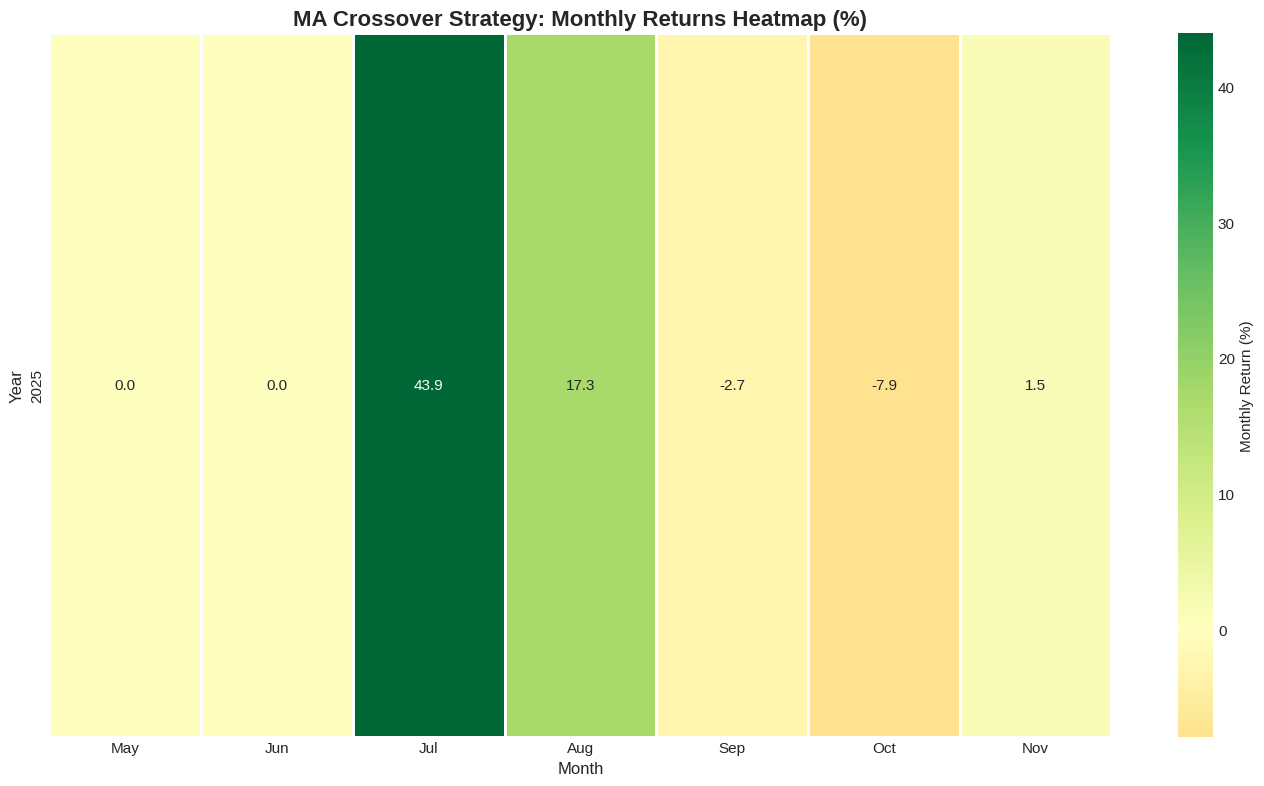

✅ Chart 4: Monthly returns heatmap


In [18]:
# Calculate monthly returns
df_monthly = df_backtest[['Strategy_Return']].copy()
df_monthly['Year'] = df_monthly.index.year
df_monthly['Month'] = df_monthly.index.month

# Group by year and month
monthly_returns = df_monthly.groupby(['Year', 'Month'])['Strategy_Return'].sum() * 100
monthly_returns_pivot = monthly_returns.unstack(fill_value=0)

# Create heatmap
fig, ax = plt.subplots(figsize=(14, 8))

sns.heatmap(monthly_returns_pivot, annot=True, fmt='.1f', cmap='RdYlGn', 
            center=0, linewidths=1, cbar_kws={'label': 'Monthly Return (%)'}, ax=ax)

ax.set_title('MA Crossover Strategy: Monthly Returns Heatmap (%)', fontsize=16, fontweight='bold')
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Year', fontsize=12)

# Only set labels for months that exist in the data
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
actual_months = sorted(monthly_returns_pivot.columns)
actual_month_labels = [month_labels[m-1] for m in actual_months]
ax.set_xticklabels(actual_month_labels, rotation=0)

plt.tight_layout()
plt.show()

print("✅ Chart 4: Monthly returns heatmap")

### Chart 5: Returns Distribution (Strategy vs Buy-and-Hold)

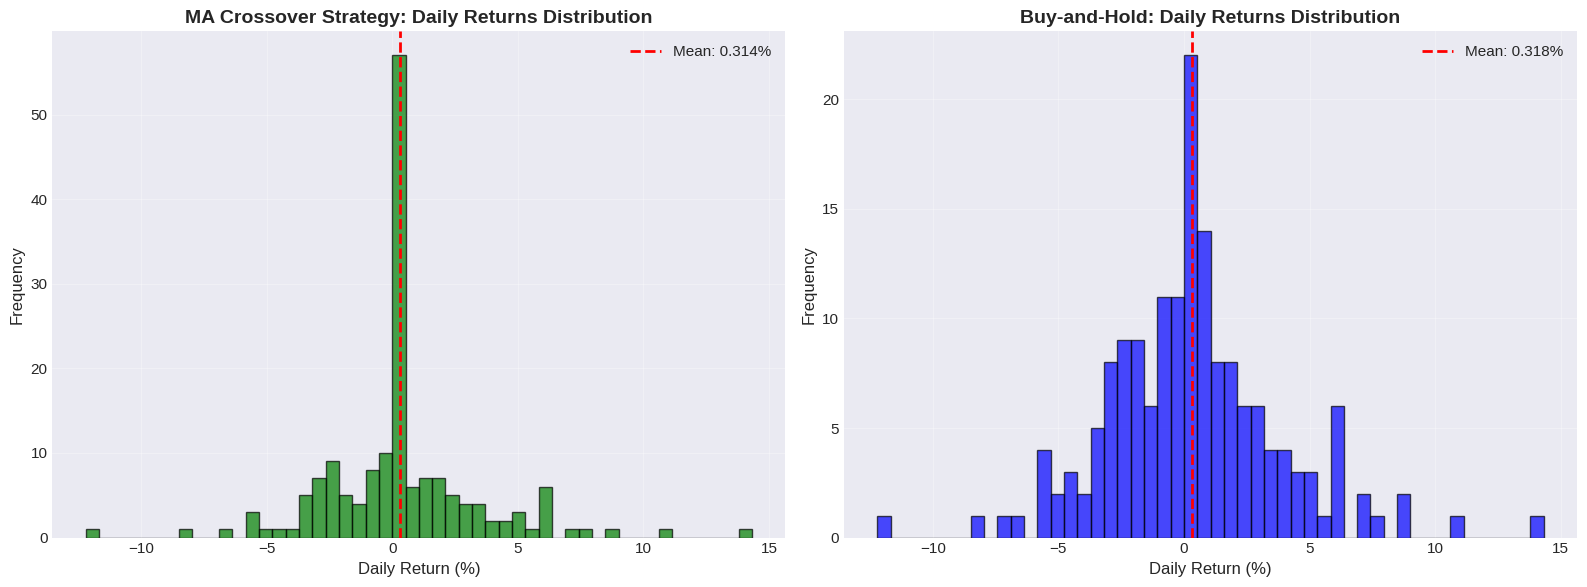

✅ Chart 5: Returns distribution comparison


In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Strategy returns distribution
ax1.hist(df_backtest['Strategy_Return'] * 100, bins=50, color='green', alpha=0.7, edgecolor='black')
ax1.axvline(x=df_backtest['Strategy_Return'].mean() * 100, color='red', 
            linestyle='--', linewidth=2, label=f'Mean: {df_backtest["Strategy_Return"].mean() * 100:.3f}%')
ax1.set_title('MA Crossover Strategy: Daily Returns Distribution', fontsize=14, fontweight='bold')
ax1.set_xlabel('Daily Return (%)', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Buy-and-hold returns distribution
ax2.hist(df_backtest['Daily_Return'] * 100, bins=50, color='blue', alpha=0.7, edgecolor='black')
ax2.axvline(x=df_backtest['Daily_Return'].mean() * 100, color='red', 
            linestyle='--', linewidth=2, label=f'Mean: {df_backtest["Daily_Return"].mean() * 100:.3f}%')
ax2.set_title('Buy-and-Hold: Daily Returns Distribution', fontsize=14, fontweight='bold')
ax2.set_xlabel('Daily Return (%)', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Chart 5: Returns distribution comparison")

### Chart 6: Signal Distribution and Market Exposure

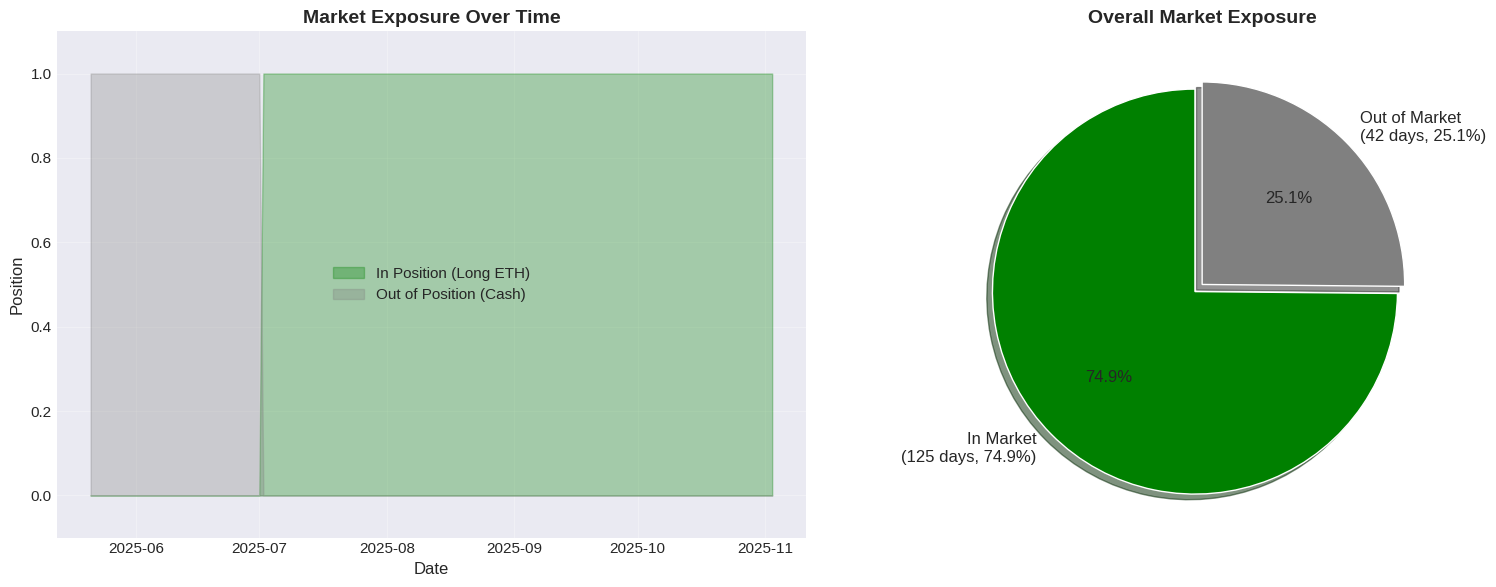

✅ Chart 6: Signal distribution and market exposure
   Days in market: 125 (74.9%)
   Days out of market: 42 (25.1%)


In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Position over time
ax1.fill_between(df_backtest.index, 0, df_backtest['Signal'], 
                 color='green', alpha=0.3, label='In Position (Long ETH)')
ax1.fill_between(df_backtest.index, 0, 1 - df_backtest['Signal'], 
                 color='gray', alpha=0.3, label='Out of Position (Cash)')
ax1.set_title('Market Exposure Over Time', fontsize=14, fontweight='bold')
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Position', fontsize=12)
ax1.set_ylim([-0.1, 1.1])
ax1.legend(loc='best')
ax1.grid(True, alpha=0.3)

# Market exposure pie chart
days_in = df_backtest['Signal'].sum()
days_out = len(df_backtest) - days_in
sizes = [days_in, days_out]
labels = [f'In Market\n({days_in} days, {market_exposure:.1f}%)', 
          f'Out of Market\n({days_out} days, {100-market_exposure:.1f}%)']
colors = ['green', 'gray']
explode = (0.05, 0)

ax2.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90, textprops={'fontsize': 12})
ax2.set_title('Overall Market Exposure', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("✅ Chart 6: Signal distribution and market exposure")
print(f"   Days in market: {days_in} ({market_exposure:.1f}%)")
print(f"   Days out of market: {days_out} ({100-market_exposure:.1f}%)")

## 7. Key Findings and Conclusions

In [21]:
print("\n" + "="*70)
print("🎯 KEY FINDINGS: MA CROSSOVER STRATEGY (50/200)")
print("="*70)

print("\n📊 PERFORMANCE SUMMARY:")
print(f"   Strategy Return: {strategy_return:+.2f}%")
print(f"   Buy-and-Hold Return: {buyhold_return:+.2f}%")
print(f"   Outperformance: {outperformance:+.2f}%")

print("\n🎲 RISK METRICS:")
print(f"   Strategy Sharpe Ratio: {strategy_sharpe:.2f}")
print(f"   Buy-and-Hold Sharpe: {buyhold_sharpe:.2f}")
print(f"   Strategy Max Drawdown: {max_strategy_drawdown:.2f}%")
print(f"   Buy-and-Hold Max Drawdown: {max_buyhold_drawdown:.2f}%")

print("\n📈 TRADING STATISTICS:")
print(f"   Total Signals: {num_buys + num_sells}")
print(f"   Buy Signals: {num_buys}")
print(f"   Sell Signals: {num_sells}")
print(f"   Market Exposure: {market_exposure:.1f}%")
print(f"   Win Rate (days): {win_rate:.1f}%")

print("\n💡 INSIGHTS:")

if outperformance > 5:
    print("   ✅ Strategy significantly OUTPERFORMED buy-and-hold")
    print("   ✅ MA crossover captured major trends effectively")
elif outperformance > 0:
    print("   ✅ Strategy slightly outperformed buy-and-hold")
    print("   ⚠️  But consider transaction costs in real trading")
else:
    print("   ❌ Strategy UNDERPERFORMED buy-and-hold")
    print("   ⚠️  Trend-following struggles in choppy/sideways markets")

if market_exposure < 60:
    print(f"   📊 Strategy was out of market {100-market_exposure:.1f}% of the time")
    print("   💰 This reduces risk exposure but may miss sudden rallies")

if num_buys + num_sells < 5:
    print(f"   ⚠️  Only {num_buys + num_sells} signals generated (low sample size)")
    print("   📅 Consider testing over longer time period")

print("\n🎓 LESSONS LEARNED:")
print("   1. MA crossover is a TREND-FOLLOWING strategy")
print("   2. Works best in strong trending markets (up or down)")
print("   3. Struggles in choppy/sideways markets (whipsaws)")
print("   4. Reduces drawdowns by exiting during downtrends")
print("   5. Always compare to buy-and-hold benchmark")
print("   6. Consider transaction costs in real-world implementation")

print("\n🔧 POTENTIAL IMPROVEMENTS:")
print("   - Add filters to avoid false signals (volume, RSI)")
print("   - Use adaptive moving averages (EMA instead of SMA)")
print("   - Implement partial position sizing (not all-in/all-out)")
print("   - Combine with other indicators for confirmation")
print("   - Test different MA periods (e.g., 20/50, 100/200)")

print("\n" + "="*70)
print("✅ Analysis complete! Notebook 3b finished.")
print("="*70)


🎯 KEY FINDINGS: MA CROSSOVER STRATEGY (50/200)

📊 PERFORMANCE SUMMARY:
   Strategy Return: +54.96%
   Buy-and-Hold Return: +52.91%
   Outperformance: +2.06%

🎲 RISK METRICS:
   Strategy Sharpe Ratio: 1.88
   Buy-and-Hold Sharpe: 1.71
   Strategy Max Drawdown: -22.36%
   Buy-and-Hold Max Drawdown: -22.36%

📈 TRADING STATISTICS:
   Total Signals: 1
   Buy Signals: 1
   Sell Signals: 0
   Market Exposure: 74.9%
   Win Rate (days): 54.4%

💡 INSIGHTS:
   ✅ Strategy slightly outperformed buy-and-hold
   ⚠️  But consider transaction costs in real trading
   ⚠️  Only 1 signals generated (low sample size)
   📅 Consider testing over longer time period

🎓 LESSONS LEARNED:
   1. MA crossover is a TREND-FOLLOWING strategy
   2. Works best in strong trending markets (up or down)
   3. Struggles in choppy/sideways markets (whipsaws)
   4. Reduces drawdowns by exiting during downtrends
   5. Always compare to buy-and-hold benchmark
   6. Consider transaction costs in real-world implementation

🔧 POTE

---

## Summary

This notebook implemented and backtested a **50-day vs 200-day moving average crossover strategy** on ETH.

**What we learned:**
1. How to calculate moving averages and detect crossovers
2. How to generate trading signals (Golden Cross = buy, Death Cross = sell)
3. How to backtest a strategy with proper position tracking
4. How to calculate performance metrics (Sharpe, drawdown, win rate)
5. How to compare strategy performance vs buy-and-hold benchmark

**Next Steps:**
- Notebook 3c: Funding Rate Arbitrage
- Notebook 3d: RWA Tokenization Analysis

---